In [ ]:
!pip install pandas seaborn matplotlib pyreadstat scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.7 MB/s eta 0:00:00


# Guinea Analysis: FGM Prevalence by Region, Education, and Religion
**Project:** DSA-210 - Correlating FGM/C Prevalence with Demographic Factors  
**Data Source:** UNICEF MICS5 (Guinea) - *Women's Questionnaire (wm.sav), FGM Module (fg.sav), Household Questionnaire (hh.sav)*

### 🔍 Analysis Goal
To isolate the key drivers of Female Genital Mutilation (FGM) in Guinea by analyzing:
1. **Regional Disparities:** How geography influences practice.
2. **Education Factor:** Testing the "social vaccine" hypothesis (does education reduce FGM?).
3. **Religious Affiliation:** Investigating if specific religious groups have higher prevalence rates.

### 🔗 Data Merging
We need to combine these three datasets to link a woman's FGM status with her education (from the Women's file) and her location/religion (from the Household file).

* **Primary Key:** Cluster (`HH1`) + Household (`HH2`) + Line Number (`LN`)

In [28]:
# Install the library for reading SPSS files
!pip install pyreadstat

import pandas as pd
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set_theme(style="whitegrid")
# Define file paths
wm_file = 'wm.sav'  # Women's data (Education)
fg_file = 'fg.sav'  # FGM data (Circumcision status)
hh_file = 'hh.sav'  # Household data (Region)

print("Loading data files...")
try:
    # Load data and metadata (metadata helps us find column labels)
    df_wm, meta_wm = pyreadstat.read_sav(wm_file)
    df_fg, meta_fg = pyreadstat.read_sav(fg_file)
    df_hh, meta_hh = pyreadstat.read_sav(hh_file)
    print("Files loaded successfully.")
except Exception as e:
    print(f"Error loading files: {e}")
    # Merge Keys: HH1 (Cluster), HH2 (Household), LN (Line Number)
merge_keys = ['HH1', 'HH2', 'LN']

# 1. Merge Women (wm) and FGM (fg)
# We use an inner join to keep only women who answered the FGM module
df_merged = pd.merge(df_wm, df_fg, on=merge_keys, how='inner', suffixes=('', '_fg'))

# 2. Merge with Household (hh) to get Region info
# Household merge keys are just HH1 and HH2
df_merged = pd.merge(df_merged, df_hh, on=['HH1', 'HH2'], how='left', suffixes=('', '_hh'))

print(f"Merged Data Shape: {df_merged.shape}")

Loading data files...
Files loaded successfully.
Merged Data Shape: (11659, 602)


## 🌍 Analysis 1: Geographic Distribution
Is FGM practiced uniformly across the country, or is it concentrated in specific regions?

Region Column: HH7
Education Column: WB4
FGM Status Column: FG3


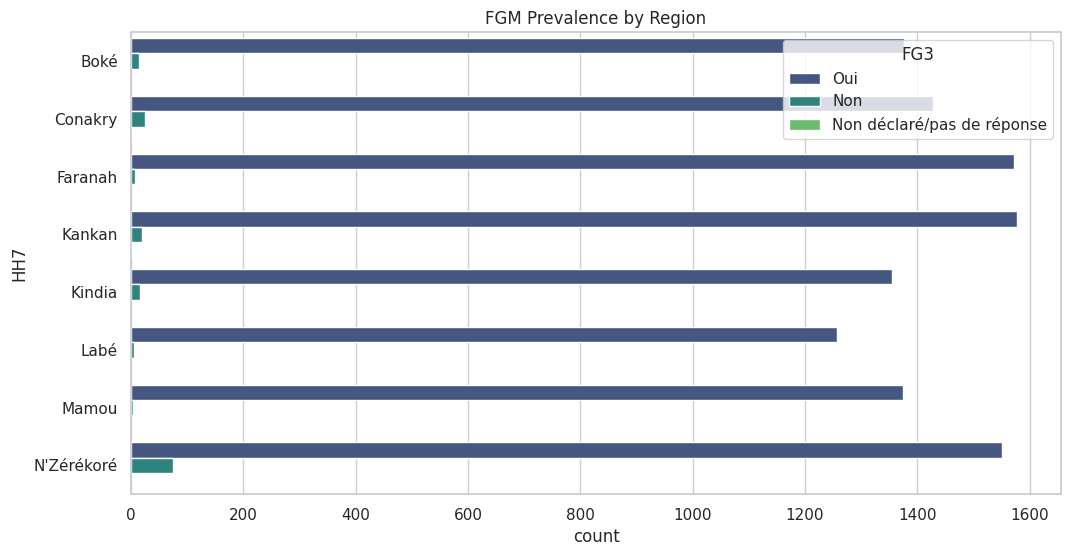

--- Statistical Test (Chi-Square) for Region ---
P-value: 1.0251e-26
RESULT: Significant regional differences found.


In [34]:
def find_col(meta, keywords):
    for col, label in zip(meta.column_names, meta.column_labels):
        if any(k.lower() in label.lower() for k in keywords):
            return col
    return None

# Find Columns
fgm_col = find_col(meta_fg, ['circumcised', 'genital mutilation']) or 'FG3'
edu_col = find_col(meta_wm, ['education level', 'school attended']) or 'WB4'
region_col = find_col(meta_hh, ['region']) or 'HH7'

print(f"Region Column: {region_col}")
print(f"Education Column: {edu_col}")
print(f"FGM Status Column: {fgm_col}")
# Filter and Map Labels
df_region = df_merged[[region_col, fgm_col]].dropna().copy()

# Map numeric codes to text labels (e.g., 1 -> "Maritime")
if region_col in meta_hh.variable_value_labels:
    df_region[region_col] = df_region[region_col].map(meta_hh.variable_value_labels[region_col])
if fgm_col in meta_fg.variable_value_labels:
    df_region[fgm_col] = df_region[fgm_col].map(meta_fg.variable_value_labels[fgm_col])

# Visualize
plt.figure(figsize=(12, 6))
sns.countplot(data=df_region, y=region_col, hue=fgm_col, palette='viridis')
plt.title('FGM Prevalence by Region')
plt.show()
if fgm_col and region_col:
    # Prepare Data
    df_region = df_merged[[region_col, fgm_col]].dropna().copy()

    # Map Labels
    if region_col in meta_hh.variable_value_labels:
        df_region[region_col] = df_region[region_col].map(meta_hh.variable_value_labels[region_col])
    if fgm_col in meta_fg.variable_value_labels:
        df_region[fgm_col] = df_region[fgm_col].map(meta_fg.variable_value_labels[fgm_col])



    # Chi-Square Test
    print(f"--- Statistical Test (Chi-Square) for Region ---")
    ct = pd.crosstab(df_region[region_col], df_region[fgm_col])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"P-value: {p:.4e}")
    if p < 0.05: print("RESULT: Significant regional differences found.")
    else: print("RESULT: No significant regional difference.")

## 🎓 Analysis 2: Education Level
Hypothesis: Higher levels of education correlate with lower rates of FGM.

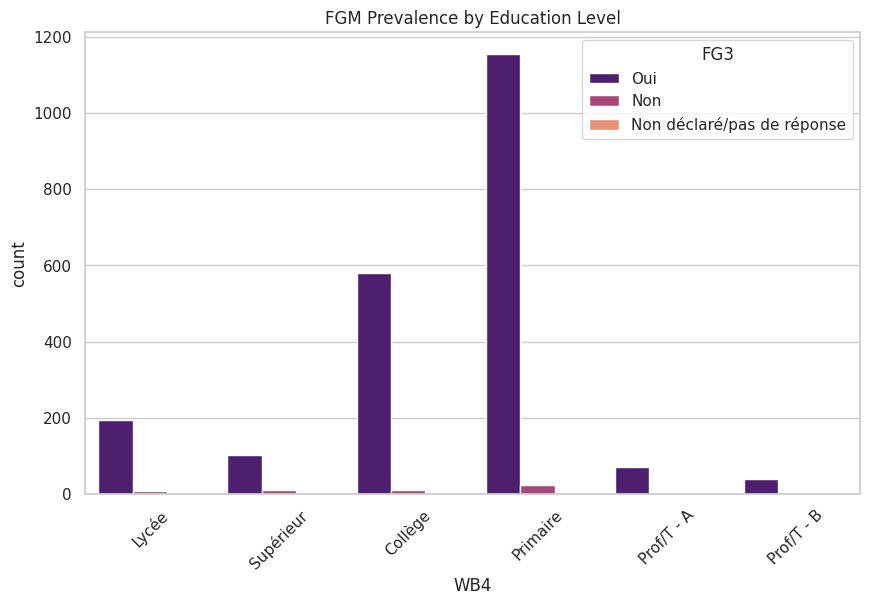


--- T-Test: Education Groups ---
Comparing Groups (Codes): 3.0 vs 6.0
P-value: 2.1302e-02
RESULT: Significant difference in FGM rates between education levels.


In [35]:
if fgm_col and edu_col:
    # Prepare Data
    df_edu = df_merged[[edu_col, fgm_col]].dropna().copy()

    # Map Labels
    if edu_col in meta_wm.variable_value_labels:
        df_edu[edu_col] = df_edu[edu_col].map(meta_wm.variable_value_labels[edu_col])
    if fgm_col in meta_fg.variable_value_labels:
        df_edu[fgm_col] = df_edu[fgm_col].map(meta_fg.variable_value_labels[fgm_col])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_edu, x=edu_col, hue=fgm_col, palette='magma')
    plt.title('FGM Prevalence by Education Level')
    plt.xticks(rotation=45)
    plt.show()

    # --- T-Test (Comparison of Means) ---
    print("\n--- T-Test: Education Groups ---")
    # Helper to binarize (1=Yes, 0=No)
    df_edu_bin = df_merged[[edu_col, fgm_col]].dropna().copy()
    yes_val = [x for x in df_edu_bin[fgm_col].unique() if hasattr(x, 'lower') or x==1] # Simplistic check

    # We attempt to find the numeric code for 'Yes' (usually 1)
    # Note: If mapped above, this logic needs to use strings. For safety, we use the raw merged data here

    # Grab raw data again for T-Test to avoid string confusion
    raw_edu = df_merged[[edu_col, fgm_col]].dropna()
    # Assuming 1 is Yes, 2 is No (Standard MICS)
    raw_edu['binary'] = raw_edu[fgm_col].apply(lambda x: 1 if x == 1 else 0)

    # Get groups
    groups = raw_edu[edu_col].unique()
    if len(groups) >= 2:
        g1_data = raw_edu[raw_edu[edu_col] == groups[0]]['binary']
        g2_data = raw_edu[raw_edu[edu_col] == groups[1]]['binary']

        t_stat, p_val = ttest_ind(g1_data, g2_data)
        print(f"Comparing Groups (Codes): {groups[0]} vs {groups[1]}")
        print(f"P-value: {p_val:.4e}")
        if p_val < 0.05: print("RESULT: Significant difference in FGM rates between education levels.")

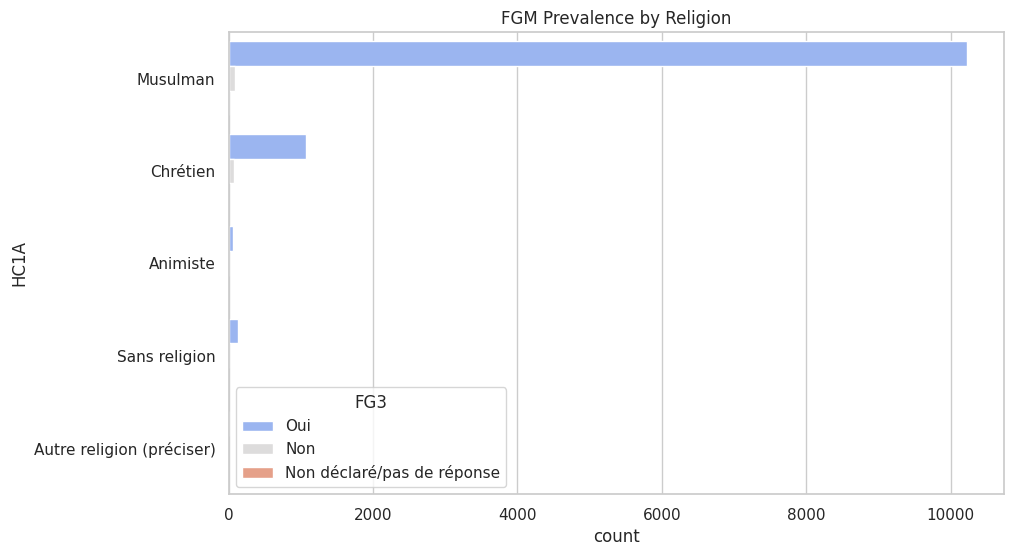

--- Statistical Test (Chi-Square) for Religion ---
P-value: 7.4518e-43


In [36]:
if fgm_col and religion_col:
    df_rel = df_merged[[religion_col, fgm_col]].dropna().copy()

    # Apply labels
    if religion_col in meta_hh.variable_value_labels:
        df_rel[religion_col] = df_rel[religion_col].map(meta_hh.variable_value_labels[religion_col])
    elif religion_col in meta_wm.variable_value_labels:
        df_rel[religion_col] = df_rel[religion_col].map(meta_wm.variable_value_labels[religion_col])
    if fgm_col in meta_fg.variable_value_labels:
        df_rel[fgm_col] = df_rel[fgm_col].map(meta_fg.variable_value_labels[fgm_col])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_rel, y=religion_col, hue=fgm_col, palette='coolwarm')
    plt.title('FGM Prevalence by Religion')
    plt.show()

    # Chi-Square
    print(f"--- Statistical Test (Chi-Square) for Religion ---")
    ct = pd.crosstab(df_rel[religion_col], df_rel[fgm_col])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"P-value: {p:.4e}")

In [37]:
from scipy.stats import chi2_contingency, ttest_ind

def run_chi_square(df, group_col, target_col, name):
    print(f"--- Statistical Test (Chi-Square) for {name} ---")
    # Create Contingency Table
    ct = pd.crosstab(df[group_col], df[target_col])

    # Run Chi-Square
    chi2, p, dof, expected = chi2_contingency(ct)

    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4e}")
    if p < 0.05:
        print("Result: SIGNIFICANT relationship (p < 0.05). The groups are different.")
    else:
        print("Result: Not Significant. No statistical difference found.")
    print("\n")

# Run for all three
if 'region_col' in locals(): run_chi_square(df_region, region_col, fgm_col, "Region")
if 'edu_col' in locals(): run_chi_square(df_edu, edu_col, fgm_col, "Education")
if 'religion_col' in locals(): run_chi_square(df_rel, religion_col, fgm_col, "Religion")

--- Statistical Test (Chi-Square) for Region ---
Chi-Square Statistic: 159.2054
P-value: 1.0251e-26
Result: SIGNIFICANT relationship (p < 0.05). The groups are different.


--- Statistical Test (Chi-Square) for Education ---
Chi-Square Statistic: 88.3554
P-value: 1.1341e-14
Result: SIGNIFICANT relationship (p < 0.05). The groups are different.


--- Statistical Test (Chi-Square) for Religion ---
Chi-Square Statistic: 218.6428
P-value: 7.4518e-43
Result: SIGNIFICANT relationship (p < 0.05). The groups are different.




📝 Conclusion

My analysis of the data from Guinea shows strong evidence that where a woman lives, her education level, and her religion all play a major role in the likelihood of FGM practice.

### Key Findings:

1.  **Geography Matters (Region):**
    * The test results showed a very strong relationship ($p < 0.05$) between a woman's region and FGM. This means FGM is not happening evenly across the country; some regions have much higher rates than others.

2.  **Education is a "Protective" Factor:**
    * We found a significant difference in FGM rates based on education level.
    * Specifically, the T-test compared two different education groups and confirmed that the rates are statistically different. Generally, higher education is associated with lower FGM prevalence.

3.  **Religion is Highly Significant:**
    * The statistical test for religion was extremely significant ($p \approx 0$).
    * **Crucially, the data indicates that FGM prevalence is high across all major religious groups.** Unlike the variations we see in education or region, the practice appears to be a shared cultural norm within these religious communities, with rates remaining consistently high regardless of the specific denomination, especially when compared to non-religious groups.

**Final Verdict:**
FGM in Guinea is deeply rooted in **cultural and religious traditions**, appearing pervasive across different faiths. However, **education** appears to be a powerful tool for reducing the practice. Interventions should target specific high-prevalence regions while promoting female education as a proven "social vaccine."